In [4]:
import numpy as np
import fst
import matplotlib.pyplot as P
%matplotlib inline

# HMM简介

隐马尔可夫模型(HMMs)是一个用于建模时序数据的模型。它的优点是非常直观而且容易实现。你可以参考[Wikipedia](https://en.wikipedia.org/wiki/Hidden_Markov_model) 或者google搜索到很多相关资料。([这篇文章](http://www.comp.leeds.ac.uk/roger/HiddenMarkovModels/html_dev/main.html) 是我最喜欢的文章之一。

对于语音识别来说，首先需要阅读的是[Rabiner]的论文(http://www.ee.columbia.edu/~dpwe/e6820/papers/Rabiner89-hmm.pdf)，这篇论文非常写到很容易理解而且是专门讨论它在语音识别中的应用。如果这是你第一次了解它，你可能需要先阅读这些相关资料。这个notebook会简单的回顾它的一些要点然后展示怎么用Python来实现。


## HMM 算法

Rabiner的论文提到了HMM有3个问题： 

  1. 给定模型(参数)，计算观察的概率，也就是P(O|M) - 这需要使用前向算法 
  2. 给定模型(参数)和观察，计算最可能的状态序列，也就是$\underset{S}{argmax}P(S|O;M)$。这需要使用Viterbi算法。 
  3. 学习问题，调整模型参数，使得概率P(O|M)最大(最大似然)。这需要Baum-Welch算法，也叫前向后向算法。
  
HMM有如下的参数定义：

  * 发射概率 - 通常我们使用高斯混合模型(GMM)，但是我们也可以使用深度神经网络(比如MLP)。为了与Rabiner的论文一致，我们假设输出是离散的。因此可以用概率分布函数$b_{jk}$来描述。它表示给定状态j出现观察k的概率。
  * 隐状态 - 在我们的例子中，隐状态是我们需要识别的单元：比如因素(phonemes)，但是也有可能是其它的单元比如词。 
  * 转移概率 - 从一个状态跳转到另一个状态的概率  
  * 先验概率 - 系统处于不同初始状态的概率。(如果忽略也问题不大)
  
为了便于阅读，我们这里使用和Rabiner论文一致的记号:
  * 发射概率我们用$b_{jk}$表示。
  * 跳转概率用$a_{ij}$表示。
  * 先验概率用$pi_i$表示。
  
## 示例模型

这里我们会随机的生成一些值来演示算法。我们这里的示例HMM有3个状态，观察有4种可能值。观察的长度是5。

我们把它们定义成常量。

In [5]:
N=3
M=4
T=5

#### 观察序列

我们先随机生成一个观察序列：

In [6]:
O=np.random.randint(0,M,T)
print(O)

[2 2 0 2 1]


发射概率可以用一个矩阵来表示。这个矩阵的大小是3x4，每一行表示一个状态，$b_{jk}$表示状态j发射观察k的概率。


In [57]:
b=np.random.random((N,M))
b/=np.array(b.sum(axis=1, keepdims=True))
print(b)

[[0.48229459 0.27721979 0.12239203 0.11809359]
 [0.11822906 0.14038183 0.42902164 0.31236747]
 [0.34614273 0.10475221 0.38320261 0.16590244]]


因为是概率，因此要求$\sum_kb_{jk}=1$，也就是每一行加起来等于1。

In [58]:
print(b.sum(axis=1))

[1. 1. 1.]


给定这些概率和一个观察序列，我们很容易计算的不同时刻处于不同状态的发射概率：

In [59]:
ob=np.zeros((T,N))
for t in range(T):
    for i in range(N):
        ob[t,i]=b[i,O[t]]
print(ob)

[[0.12239203 0.42902164 0.38320261]
 [0.12239203 0.42902164 0.38320261]
 [0.48229459 0.11822906 0.34614273]
 [0.12239203 0.42902164 0.38320261]
 [0.27721979 0.14038183 0.10475221]]


或者更加简洁高效的写法：

In [60]:
ob=b.T[O]
print(ob)

[[0.12239203 0.42902164 0.38320261]
 [0.12239203 0.42902164 0.38320261]
 [0.48229459 0.11822906 0.34614273]
 [0.12239203 0.42902164 0.38320261]
 [0.27721979 0.14038183 0.10475221]]


注意我们这里的示例使用的是离散的输出，我们用一个发射概率矩阵就可以表示了，但是在实际的系统中，我们通常使用一个模型，比如GMM或者MLP来表示这个发射概率。这里为了简单起见我们使用了离散的输出，但是读者应该知道在实际的系统中很少使用离散的输出。

#### 状态转移矩阵

状态转移矩阵是一个3x3的矩阵，它的每一行加起来是1：

In [63]:
a=np.random.random((N,N))
a/=np.array([a.sum(axis=-1)]).T
print(a)
print(a.sum(axis=1))

[[0.39884173 0.3486846  0.25247367]
 [0.08072832 0.59021607 0.32905562]
 [0.25993654 0.25873506 0.4813284 ]]
[1. 1. 1.]


#### 先验概率

下面我们随机的生成先验概率。我们可以设置随机值，也可以让所有的状态的先验概率相等。


In [13]:
pi=np.random.random(N)
pi/=pi.sum()
print(pi)

[0.23738012 0.47646268 0.28615719]


#### 最终的模型

为了更容易阅读，我们把这些概率放到一个tuple里：

In [14]:
hmm=(O,pi,a,b,N,M,T)

下面把模型保存到磁盘：

In [15]:
import pickle

with open('../data/hmm.pkl','wb') as f:
    pickle.dump(hmm,f,pickle.HIGHEST_PROTOCOL)

### 前向算法

下面会直接实现Rabiner的论文里的算法。注意原文的下标是1开始的，而程序的下标是0开始。

In [16]:
def forward(O,pi,a,b,N,M,T):
    fwd=np.zeros((T,N))

    #初始化
    for i in range(N):
        fwd[0,i]=pi[i]*b[i,O[0]]

    #递推
    for t in range(T-1):
        for j in range(N):
            s=0
            for i in range(N):
                s+=fwd[t,i]*a[i,j]
            fwd[t+1,j]=s*b[j,O[t+1]]
            
    return fwd

print(forward(*hmm))

[[1.05337157e-01 1.57878382e-01 6.43555966e-02]
 [4.00636322e-02 4.24970349e-02 2.45214076e-02]
 [8.41601229e-03 2.33586277e-03 2.20264128e-02]
 [1.66340860e-03 5.68899442e-03 2.66746419e-03]
 [9.48980897e-04 1.19242838e-04 2.32921745e-03]]


我们也可以使用Numpy更加高效的实现：

In [17]:
def forward(O,pi,a,b,N,M,T):
    fwd=np.zeros((T,N))

    #初始化
    fwd[0]=pi*b[:,O[0]]

    #递推:
    for t in range(T-1):
        fwd[t+1]=np.dot(fwd[t],a)*b[:,O[t+1]]
    
    return fwd

print(forward(*hmm))

[[1.05337157e-01 1.57878382e-01 6.43555966e-02]
 [4.00636322e-02 4.24970349e-02 2.45214076e-02]
 [8.41601229e-03 2.33586277e-03 2.20264128e-02]
 [1.66340860e-03 5.68899442e-03 2.66746419e-03]
 [9.48980897e-04 1.19242838e-04 2.32921745e-03]]


前面计算了到最后一个时刻的某个状态的所有路径的概率累加和，为了计算所有路径的累加和，我们需要把最好一个时刻的所有概率再加起来：

In [19]:
def full_prob(fwd):
    return fwd[-1].sum()

print(full_prob(forward(*hmm)))

0.0033974411807013404


### Viterbi算法

最简单算法只考虑某一个时刻最可能的状态，也就是根据发射概率找出最可能的状态。$s_i=argmax_sP(o_i|s)$。

In [20]:
np.argmax(ob,axis=1)

array([0, 0, 2, 0, 2])

上面的序列不会考虑上下文。但是HMM认为有些状态之间的跳转概率更大，因此即使某个发射概率可能比另外一个稍大一些，但是如果从前面的状态跳转到它的概率很低的话，我们也应该选择跳转概率更大的那个。所以我们需要考虑整个序列，综合考虑跳转概率和发射概率。

In [21]:
def viterbi(O,pi,a,b,N,M,T):
    d=np.zeros((T,N))
    ph=np.zeros((T,N),dtype=np.int)

    #初始化
    for i in range(N):
        d[0,i]=pi[i]*b[i,O[0]]
        ph[0,i]=0

    #递推
    for t in range(1,T):
        for j in range(N):
            m=np.zeros(N)
            for i in range(N):
                m[i]=d[t-1,i]*a[i,j]
            ph[t,j]=m.argmax()
            d[t,j]=m.max()*b[j,O[t]]

    #结束时刻
    m=np.zeros(N)
    for i in range(N):
        m[i]=d[T-1,i]
    Pv=m.max()

    #back-tracking
    Q=np.zeros(T,dtype=np.int)
    Q[T-1]=m.argmax()
    for t in reversed(range(T-1)):
        Q[t]=ph[t+1,Q[t+1]]
        
    return Q

print(viterbi(*hmm))

[0 1 2 1 2]


稍快一点的Numpy实现：

In [22]:
def viterbi(O,pi,a,b,N,M,T):
    d=np.zeros((T,N))
    ph=np.zeros((T,N),dtype=np.int)

    #初始化
    d[0]=pi*b[:,O[0]]
    ph[0]=0

    #递推
    for t in range(1,T):
        m=d[t-1]*a.T        
        ph[t]=m.argmax(axis=1)
        d[t]=m[np.arange(N),ph[t]]*b[:,O[t]]    

    #结束时刻
    Q=np.zeros(T,dtype=np.int)
    Q[T-1]=np.argmax(d[T-1])
    Pv=d[T-1,Q[T-1]]

    #back-tracking
    for t in reversed(range(T-1)):
        Q[t]=ph[t+1,Q[t+1]]

    return Q

print(viterbi(*hmm))

[0 1 2 1 2]


如果我们把先验概率和转移概率设置成均匀分布，那么Viterbi得到的路径和前面最大似然的路径是相同的。


### 前向后向算法

前向算法已经实现过了，这里我们实现后向算法：

In [23]:
def backward(O,pi,a,b,N,M,T):
    bk=np.zeros((T,N))
    #初始化
    for i in range(N):
        bk[T-1,i]=1
    #推导:
    for t in reversed(range(T-1)):
        for i in range(N):
            s=0
            for j in range(N):
                s+=a[i,j]*b[j,O[t+1]]*bk[t+1,j]            
            bk[t,i]=s
    return bk

print(backward(*hmm))

[[0.01161635 0.00942741 0.01065058]
 [0.0218539  0.04098234 0.03181981]
 [0.11128824 0.0895978  0.10222045]
 [0.20510646 0.39447244 0.30445164]
 [1.         1.         1.        ]]


Numpy的实现：

In [24]:
def backward(O,pi,a,b,N,M,T):
    bk=np.zeros((T,N))
    #初始化:
    bk[T-1]=1
    #递推:
    for t in reversed(range(T-1)):
        bk[t]=np.dot(bk[t+1]*b[:,O[t+1]],a.T)
    return bk

print(backward(*hmm))

[[0.01161635 0.00942741 0.01065058]
 [0.0218539  0.04098234 0.03181981]
 [0.11128824 0.0895978  0.10222045]
 [0.20510646 0.39447244 0.30445164]
 [1.         1.         1.        ]]


根据定义，前向概率是$P(o_1,...,o_t,s_t=j|M)$，而后向概率是$P(o_{t+1},...,o_T|s_t=j;M)$。状态占用概率$\gamma_t(j)=P(s_t=j|O)=\frac{\alpha_t(j)\beta_t(j)}{P(O)}$，而P(O)就是full_prob函数得到的结果。在语音识别章节有详细的推导过程，请读者参考相关内容。

In [25]:
def gamma(fwd,bk,fp):
    gm=np.zeros((T,N))
    for t in range(T):
        for i in range(N):
            gm[t,i]=(fwd[t,i]*bk[t,i])/fp
    return gm

print(gamma(forward(*hmm),backward(*hmm),full_prob(forward(*hmm))))

[[0.36016307 0.43808971 0.20174722]
 [0.2577077  0.5126293  0.229663  ]
 [0.27567901 0.06160171 0.66271928]
 [0.10042141 0.66054168 0.23903691]
 [0.27932224 0.03509784 0.68557992]]


Numpy的一行实现：

In [26]:
def gamma(fwd,bk,fp):
    return (fwd*bk)/fp

print(gamma(forward(*hmm),backward(*hmm),full_prob(forward(*hmm))))

[[0.36016307 0.43808971 0.20174722]
 [0.2577077  0.5126293  0.229663  ]
 [0.27567901 0.06160171 0.66271928]
 [0.10042141 0.66054168 0.23903691]
 [0.27932224 0.03509784 0.68557992]]


我们可以把这3个概率绘制出来进行比较。我们可以发现前向概率随着时间的增加指数衰减(后向算法也类似，只是方向相反)。把它们加到一起就可以找到每个时刻最可能的状态。白色表示概率较大，因此从图中我们可以知道1-5个时刻最优的状态是[1,1,2,1,2]，这回Viterbi算法得到的[0,1,2,1,2]是很接近的。

Text(0.5, 1.0, 'Full')

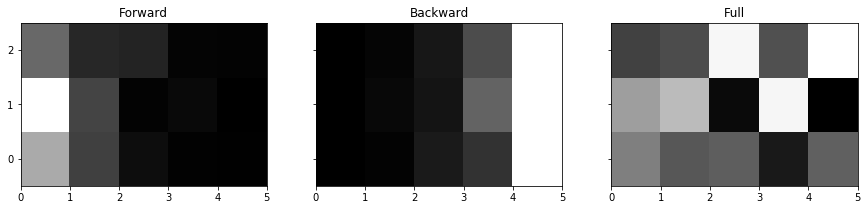

In [27]:
fig,ax=P.subplots(1,3,figsize=(15,3),sharey=True)


ax[0].pcolormesh(forward(*hmm).T,cmap=P.cm.gray)
ax[0].set_yticks(np.arange(0,N)+.5)
ax[0].set_yticklabels(np.arange(0,N))
ax[0].set_title('Forward')

ax[1].pcolormesh(backward(*hmm).T,cmap=P.cm.gray)
ax[1].set_title('Backward')

g=gamma(forward(*hmm),backward(*hmm),full_prob(forward(*hmm)))
ax[2].pcolormesh(g.T,cmap=P.cm.gray)
ax[2].set_title('Full')


注意我们可以抽取很多序列，它们的含义是不同的。

  * 我们可以根据观察逐个时刻(独立，不考虑上下文)的计算每个时刻最可能的状态，这个状态下发射这个观察的概率最大，这不会考虑状态的跳转。我们把这个序列叫做最近观察(得到的状态)序列
  * 我们也可以考虑最佳的前向或者后向的概率，它只考虑单个方向的信息。 
  * 我们可以计算状态占用概率，得到某个时刻最可能的状态，注意这不是最优路径，它只是说明某个时刻的最可能的状态，但是它们串起来可能就不是最优的。 
  * 最后我们可以通过Viterbi算法得到最优状态序列。
  


In [28]:
print('Best observation sequence: {}'.format(np.argmax(ob,axis=1)))
print('Best forward prob. sequence: {}'.format(np.argmax(forward(*hmm),axis=1)))
print('Best backward prob. sequence: {}'.format(np.argmax(backward(*hmm),axis=1)))
g=gamma(forward(*hmm),backward(*hmm),full_prob(forward(*hmm)))
print('Best full prob. sequence: {}'.format(np.argmax(g,axis=1)))
print('Best Viterbi sequence: {}'.format(viterbi(*hmm)))

Best observation sequence: [0 0 2 0 2]
Best forward prob. sequence: [1 1 2 1 2]
Best backward prob. sequence: [0 1 0 1 0]
Best full prob. sequence: [1 1 2 1 2]
Best Viterbi sequence: [0 1 2 1 2]


### Baum-Welch算法

现在我们可以确定序列的概率，这有助于帮助我们fine-tuning状态转移概率。读者可以阅读Rabiner论文里的Baum-Welch算法，但是这在现在主流的HMM-DNN混合系统中很少使用。

总共有5个时刻，但是最后一个时刻没有跳转，而每个时刻都有3x3种可能的跳转，因此我们可以得到一个4x3x3的tensor。这就是我们介绍过$\epsilon_t(i,j)$(这里用xi表示)，它表示t时刻的状态是i而t+1时刻是状态j的概率，它可以这样计算：
$\epsilon_t(i,j)=\frac{\alpha_t(i)a_{ij}b_j(o_{t+1})\beta_{t+1}(j)}{P(O|\lambda)}$

In [29]:
def xi(fwd,bk,fp,O,pi,a,b,N,M,T):
    ret=np.zeros((T-1,N,N))
    for t in range(T-1):
        for i in range(N):
            for j in range(N):
                ret[t,i,j]=(fwd[t,i]*a[i,j]*b[j,O[t+1]]*bk[t+1,j])/fp                
    return ret

print(xi(forward(*hmm),backward(*hmm),full_prob(forward(*hmm)),*hmm))

[[[0.05759556 0.26043679 0.04213072]
  [0.19053119 0.11756602 0.1299925 ]
  [0.00958095 0.1346265  0.05753978]]

 [[0.07858843 0.03352748 0.14559178]
  [0.18399368 0.01071143 0.31792419]
  [0.0130969  0.01736279 0.19920331]]

 [[0.0431881  0.20028435 0.03220656]
  [0.02645703 0.01674273 0.01840194]
  [0.03077628 0.44351459 0.18842841]]

 [[0.03108645 0.01036278 0.05897218]
  [0.23466249 0.01067459 0.41520459]
  [0.0135733  0.01406046 0.21140315]]]


Numpy版本：

In [30]:
def xi(fwd,bk,fp,O,pi,a,b,N,M,T):
    return fwd[:-1].reshape((T-1,N,1))*a.reshape((1,N,N))*b[:,O[1:]].T.reshape((T-1,1,N))*bk[1:].reshape((T-1,1,N))/fp

print(xi(forward(*hmm),backward(*hmm),full_prob(forward(*hmm)),*hmm))

[[[0.05759556 0.26043679 0.04213072]
  [0.19053119 0.11756602 0.1299925 ]
  [0.00958095 0.1346265  0.05753978]]

 [[0.07858843 0.03352748 0.14559178]
  [0.18399368 0.01071143 0.31792419]
  [0.0130969  0.01736279 0.19920331]]

 [[0.0431881  0.20028435 0.03220656]
  [0.02645703 0.01674273 0.01840194]
  [0.03077628 0.44351459 0.18842841]]

 [[0.03108645 0.01036278 0.05897218]
  [0.23466249 0.01067459 0.41520459]
  [0.0135733  0.01406046 0.21140315]]]


我们可以估计先验概率pi——也就是初始状态的概率，它就是0时刻的状态占用概率：

In [31]:
def exp_pi(gamma):
    return gamma[0]

print(exp_pi(gamma(forward(*hmm),backward(*hmm),full_prob(forward(*hmm)))))

[0.36016307 0.43808971 0.20174722]


接下来我们可以估计跳转概率，它的计算公式为：
$\hat{a}_{ij}=\frac{\sum_t\epsilon_t(i,j)}{\sum_j \sum_t\epsilon_t(i,j)}=\frac{\sum_t\epsilon_t(i,j)}{\sum_t\gamma_t(i)}$ 。
公式看起来比较复杂，其实意思很简单：分子是所有的状态i->j的概率累加和，而分母是所有状态为i的概率和。

In [32]:
def exp_a(gamma,xi,N):
    e_a=np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            e_a[i,j]=np.sum(xi[:,i,j])/np.sum(gamma[:-1,i])
            
    return e_a

fw=forward(*hmm)
bk=backward(*hmm)
fp=full_prob(fw)
g=gamma(fw,bk,fp)
x=xi(fw,bk,fp,*hmm)

ea=exp_a(g,x,N)

print(exp_a(g,x,N))

[[0.21173506 0.50767206 0.28059288]
 [0.37997411 0.09307088 0.52695501]
 [0.05027686 0.45723049 0.49249264]]


Numpy版本：

In [33]:
def exp_a(gamma,xi,N):            
    return xi[:].sum(axis=0)/gamma[:-1].sum(axis=0).reshape(N,1)

fw=forward(*hmm)
bk=backward(*hmm)
fp=full_prob(fw)
g=gamma(fw,bk,fp)
x=xi(fw,bk,fp,*hmm)

print(exp_a(g,x,N))

[[0.21173506 0.50767206 0.28059288]
 [0.37997411 0.09307088 0.52695501]
 [0.05027686 0.45723049 0.49249264]]


最后，我们可以估计发射概率，它的计算公式为：
$\hat{b}_{jk}=\frac{\sum_t[o_t=k]\gamma_t(j)}{\sum_t\gamma_t(j)}$
它的意思是：观察为k并且状态为j的概率和除以状态为j的概率。

In [34]:
def exp_b(gamma,O,N,M):
    e_b=np.zeros((N,M))
    for j in range(N):
        for k in range(M):        
            e_b[j,k]=np.sum(gamma[O==k,j])/np.sum(gamma[:,j])
    return e_b

fw=forward(*hmm)
bk=backward(*hmm)
fp=full_prob(fw)
g=gamma(fw,bk,fp)

print(exp_b(g,O,N,M))

[[0.21650863 0.21936989 0.56412148 0.        ]
 [0.03606741 0.02054956 0.94338302 0.        ]
 [0.32828259 0.33960677 0.33211064 0.        ]]


#### 更新

Baum-Welch算法是一种EM算法，首先我们随机初始化一组参数，然后就可以用前向和后向算法计算前向后向概率，然后根据它们计算状态占用概率$\gamma_t(i)$和状态跳转概率$\epsilon_t(i,j)$，接下来就可以用这两个概率重新估计pi,$a_{ij},b_{jk}$。每次迭代都可以增加训练数据上的似然概率，我们可以不断的迭代直到收敛(到局部最优解)。

In [36]:
print('Initial probability: {}'.format(full_prob(forward(*hmm))))

hmm_new=hmm
for i in range(15):
    fw=forward(*hmm_new)
    bk=backward(*hmm_new)
    fp=full_prob(fw)
    g=gamma(fw,bk,fp)
    x=xi(fw,bk,fp,*hmm_new)

    pi_new=exp_pi(g)
    a_new=exp_a(g,x,N)
    b_new=exp_b(g,O,N,M)
    
    err=np.concatenate(((pi_new-hmm_new[1]).ravel(),(a_new-hmm_new[2]).ravel(),(b_new-hmm_new[3]).ravel()))    
    
    hmm_new=(O,pi_new,a_new,b_new,N,M,T)

    print('Update #{} probability: {} -- mean error: {}'.format(i+1,full_prob(forward(*hmm_new)),np.mean(err**2)))

Initial probability: 0.0033974411807013404
Update #1 probability: 0.011811485858807922 -- mean error: 0.042663336376065515
Update #2 probability: 0.014185384539023913 -- mean error: 0.001425943000793851
Update #3 probability: 0.020919176220825817 -- mean error: 0.00328568136827396
Update #4 probability: 0.05353066527613736 -- mean error: 0.009594967056081836
Update #5 probability: 0.16337070329542774 -- mean error: 0.010107459650387708
Update #6 probability: 0.2379400536037555 -- mean error: 0.001483043805476551
Update #7 probability: 0.24971058117425143 -- mean error: 4.5221029194295106e-05
Update #8 probability: 0.24999983233192202 -- mean error: 2.7953543736447684e-08
Update #9 probability: 0.24999999999994377 -- mean error: 9.389540929545353e-15
Update #10 probability: 0.25 -- mean error: 1.0557709064664283e-27
Update #11 probability: 0.25 -- mean error: 5.0180801380220883e-54
Update #12 probability: 0.25 -- mean error: 8.023836839987856e-106
Update #13 probability: 0.25 -- mean er

通常我们用HMM来建模一个语音单元比如因子，通常使用3-5个状态来建模一个因子，通过发音词典，我们直到一个单词对应的因子序列，我们可以把每个因子的HMM拼接起来(所有通常在语音识别系统中HMM有一个开始状态和结束状态，这样便于拼接HMM)得到一个词的HMM。类似的我们也可以把一个句子中所有词的HMM拼接起来得到一个很大的句子的HMM。我们实际标注的粒度一般是句子级别的，因此我们可以用数据来训练这个很大的HMM的参数，但是这个大的HMM是"临时"拼凑的HMM，真正的参数还是在因子级别。

而对于HMM-DNN的混合系统，我们通常不适用EM算法。对于深度神经网络，我们通常使用区分性(discriminative)训练。这要求我们的标注是帧级别的(也就是标注每一帧属于那个因子)，这显然不可能让人来标注，实际通常使用Viterbi算法来进行Force-Alignment。什么叫Force Alignment呢？普通的Viterbi算法的是在所有的路径里搜索最有的状态序列，而对于训练数据，我们是有句子级别的标注的，我们可以利用这个信息。

举个例子，句子"go home"，如果不做限制，它是在所有可能的路径里搜索，可能(虽然理论上可能性较低)解码成"/b/ae/t/"，而Force Alignment已经知道句子是"go home"了，因此已经知道HMM模型是/g əʊ h əʊ m/。
假设观察序列是：
$o_1,o_2,...,o_10$
那么所有可能的对齐方式为：
```
g g əʊ əʊ əʊ h əʊ əʊ m
g əʊ əʊ əʊ əʊ h əʊ əʊ m
...
```
它只需要从这些对齐里选择最可能的路径就行了。而不可能是：
```
b b ae ae ae ae ae ae ae t
```


或者使用其它损失函数(比如CTC)，完全抛弃HMM模型。

## 用于语音识别的HMM拓扑结构

如果要实际使用HMM来进行语音识别，我们需要扩展HMM模型的定义。我们之前定义的HMM只能用于识别一个词。

假设我们创建了一个声学模型(acoustic model)而不是简单的发射概率矩阵，声学模型可以根据声学观察(比较短时傅里叶变换滤波器组的输出)识别出因子序列。我们可以用神经网络来实现声学模型，我们可以认为神经网络的输出就是发射概率(但实际并不是，神经网络是区分性模型，它的输出是$P(s|o_t)$而不是$P(o_t|s)$)。把它替换掉原来的GMM，我们就可以把观察序列转换(识别)成因子序列。但是我们需要识别词，因此我们还需要识别词，因此我们还需要一个模型把因子训练变成词序列(实际更加复杂，声学模型输出的通常是上下文相关的因子序列，我们首先需要把它转换成上下文无关的因子序列，然后通过发音词典把它转换成词序列，最后通过语言模型选择最可能的词序列。

注意：声学模型输出的不是一个因子序列，而是很多可能的上下文相关的因子序列，当然每个序列有不同的概率得分；类似的一个上下文无关的因子序列可以转换成很多可能的词序列，它们也有不同的概率，这样的组合会非常大，我们需要从这些可能的组合中寻找概率最大的那个。

但是我们发现把观察序列变成上下文相关的因子序列的HMM H、把上下文相关的因子序列变成上下文无关的C、把上下文无关的因子序列变成词的L和把词序列变成词序列的语言模型L。都可以统一的用WFST来表示(某些复杂的文法或者N-gram需要通过近似的方法变成WFST)，而它们的层级关系可以通过WFST的composition来实现。这样我们可以把一个复杂的多层的搜索网络用WFST来表示，而且我们可以使用WFST的Determinization和Minimization算法来压缩和提高搜索速度。

# WFST

WFST定义了一种关系，给定一个输入字符串，它可以输出多个(或者零个)字符串已经对应的weight。

### 例子

 
我们这里使用[PyFst](http://pyfst.github.io/)库，它是对OpenFst的封装。我们可以定义如下的WFST：

In [37]:
f=fst.Transducer()
f.add_arc(0,0,'a','b')
f.add_arc(0,0,'b','c')
f.add_arc(0,0,'c','a')
f[0].final=True
f

TypeError: cannot use a string pattern on a bytes-like object

<StdVectorFst with 1 states>

下面我们再来创建另一个WFST，它的输入和输出是完全相同的。

输入和输出完全相同的WFST其实就是一个WFSA，我们有时候也称之为*acceptor*.

我们可以使用那还是*linear_chain*来生成一个类似链条的acceptor：

In [38]:
i=fst.linear_chain(['a','a','c','b'],syms=f.isyms)
i

TypeError: cannot use a string pattern on a bytes-like object

<StdVectorFst with 5 states>

### Composition

WFST最有用的操作就是composition。这个操作的输入是两个WFST，第一个WFST的输入字母表是A，输出字母表是B；第二个的输入字母表是B输出字母表是C，则Composition之后的WFST的输入字母表是A而输出字母表是C。


我们可以使用重载的>>运算符实现Composition操作，比如i>>f就是把i和f进行Composition。
我们发现i>>f的作用就是把i的符号做一个替换——a变成b，b变成c，c变成a。

In [39]:
o=i>>f
o.project_output()
o

TypeError: cannot use a string pattern on a bytes-like object

<StdVectorFst with 5 states>

我们也可以定义3个(链式的)WFST，然后使用union把它们并联成一个大的WFST，同时我们使用remove_epsilon去除$\epsilon$。

In [40]:
f=fst.Transducer()
f.add_arc(0,0,'a','b')
f.add_arc(0,0,'b','c')
f.add_arc(0,0,'c','a')
f.add_arc(0,0,'d','f')
f.add_arc(0,0,'e','g')
f.add_arc(0,0,'f','h')
f.add_arc(0,0,'g','e')
f.add_arc(0,0,'h','f')
f.add_arc(0,0,'x','x')
f.add_arc(0,0,'y','y')
f.add_arc(0,0,'z','z')
f[0].final=True

i1=fst.linear_chain(['a','b','c','d','e'],syms=f.isyms)
i2=fst.linear_chain(['a','b','x','y','z'],syms=f.isyms)
i3=fst.linear_chain(['g','h','c','d','e'],syms=f.isyms)
i=i1.union(i2)
i=i.union(i3)
i.remove_epsilon()
i

TypeError: cannot use a string pattern on a bytes-like object

<StdVectorFst with 16 states>

我们可以发现里面有一些重复路径，比如从状态0->1和0->6都是a，因此这个WFST是非确定的WFST，它的搜索需要回溯。我们可以使用determinize函数先把它变成确定的WFST，然后使用minimize函数得到最小的WFST，从而压缩空间和提高搜索速度。

In [41]:
i=i.determinize()
i.minimize()
i

TypeError: cannot use a string pattern on a bytes-like object

<StdVectorFst with 10 states>

对于WFST，我们可以通过project_output函数去掉输入，只保留输出，得到一个WFSA。

In [42]:
o=i>>f
o.project_output()
o

TypeError: cannot use a string pattern on a bytes-like object

<StdVectorFst with 10 states>

我们可以用WFST来实现语音识别的解码器。比如我们可以使用一个WFST把观察序列转换成上下文相关的因子序列、接着使用一个WFST把它转换成上下文无关的因子序列、再用发音词典把它转化成词序列，最后用语言模型给这个词序列加上语言模型概率得分。我们把这几个WFST composite在一起，然后使用determinize和minimize优化这个WFST。有了这个WFSt之后，给定观察序列，我们直接就可以用WFST得到最可能的词序列。


## HMM使用WFST的例子

下面我们修改前面HMM的代码，首先我们构造把观察变成状态(因子)的WFSA：

In [43]:
def obs_mat(O,b,N,T):
    f=fst.StdAcceptor()
        
    for t in range(T):
        for j in range(N):
            f.add_arc(t,t+1,str(j),-np.log(b[j,O[t]]))
        
    f[T].final=True
    
    return f

obs_fsa=obs_mat(O,b,N,T)

注意：在WFST里weight的表示方法和HMM不同，这里我们使用[tropical semiring](https://en.wikipedia.org/wiki/Tropical_geometry)。也就是把(发射)概率用-log来表示。

In [44]:
obs_fsa

TypeError: cannot use a string pattern on a bytes-like object

<StdVectorFst with 6 states>

这个FSA的输入是状态序列，输出这个状态序列的发射概率。比如给定当前的5个观察，我们可以计算状态(因子)序列为：
```
0 0 1 1 2
```
的发射概率为：
```
0.62 + 2.26 + 0.9 + 0.41 + 1.59
```


HMM除了发射概率之外还有状态的先验概率和跳转概率，我们也可以把它变成WFST：

In [45]:
def trans_mat(pi,a,N):
    f=fst.StdAcceptor()
    
    for i in range(N):
        f.add_arc(0,i+1,str(i),-np.log(pi[i]))
    
    for i in range(N):
        for j in range(N):
            f.add_arc(i+1,j+1,str(j),-np.log(a[i,j]))
        
    for i in range(N):
        f[i+1].final=True
    
    return f

tr_fsa=trans_mat(pi,a,N)

In [46]:
tr_fsa

TypeError: cannot use a string pattern on a bytes-like object

<StdVectorFst with 4 states>

我们可以把这两个FSA composition起来：

In [47]:
out_fsa=obs_fsa>>tr_fsa
out_fsa

TypeError: cannot use a string pattern on a bytes-like object

<StdVectorFst with 16 states>

上面的WFST有些复杂，它的输入是状态序列，而输出是这个状态序列的概率(先验+跳转+发射，而且是-log空间上的)，因此我们可以使用*shortest_path*来寻找最优的路径(-log最小，也就是log最大，也就是概率最大的路径），这等价于Viterbi算法：

In [48]:
sh_p=out_fsa.shortest_path()
sh_p

TypeError: cannot use a string pattern on a bytes-like object

<StdVectorFst with 6 states>

In [49]:
shp_l=[]
for p in sh_p.paths():
    for s in p:
        shp_l.append(sh_p.osyms.find(s.olabel))
print(shp_l)

['0', '1', '2', '1', '2']


In [50]:
print(viterbi(*hmm))

[0 1 2 1 2]


上面的演示了用WFST实现简单HMM解码的过程，实际的语音识别解码器需要H、C、L和G这4个WFST，实现从观察到词序列的解码过程。
